# Time-dependent example

This notebook describes the calculation of derivative information for a time-dependent problem using tlm_adjoint with the [Firedrake](https://firedrakeproject.org/) backend. Overheads associated with building the records of calculations are discussed, and a checkpointing schedule is applied.

The binomial checkpointing schedule is based on the method described in:

- Andreas Griewank and Andrea Walther, 'Algorithm 799: revolve: an implementation of checkpointing for the reverse or adjoint mode of computational differentiation', ACM Transactions on Mathematical Software, 26(1), pp. 19&ndash;45, 2000, doi: 10.1145/347837.347846

## Forward problem

We consider the solution of a linear time-dependent partial differential equation, followed by the calculation of the square of the $L^2$-norm of the final time solution. We assume real spaces and a real build of Firedrake throughout.

Specifically we consider the advection-diffusion equation in two dimensions, in the form

$$
  \partial_t u + \partial_x \psi \partial_y u - \partial_y \psi \partial_x u = \kappa \left( \partial_{xx} + \partial_{yy} \right) u,
$$

where $\psi$ vanishes on the domain boundary, and subject to zero flux boundary conditions. We consider the spatial domain $\left( x, y \right) \in \left( 0, 1 \right)^2$ and temporal domain $t \in \left[ 0, 0.1 \right]$, with $\psi \left( x, y \right) = -\sin \left( \pi x \right) \sin \left( \pi y \right)$ and $\kappa = 0.01$, and an initial condition $u \left( x, y, t=0 \right) = \exp \left[ -50 \left( \left( x - 0.75 \right)^2 + \left( y - 0.5 \right)^2 \right) \right]$.

The problem is discretized using $P_1$ continuous finite elements to represent both the solution $u$ at each time level and the stream function $\psi$. The problem is discretized in time using the implicit trapezoidal rule.

A simple implementation in Firedrake takes the form:

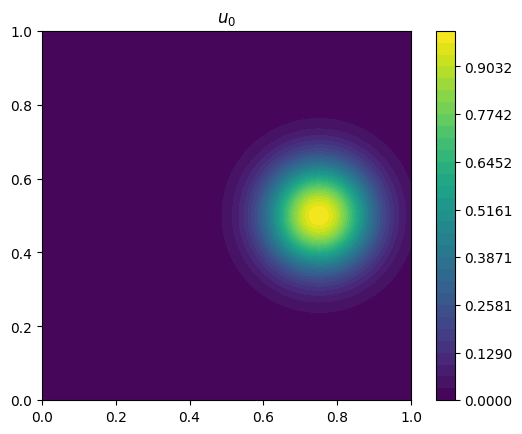

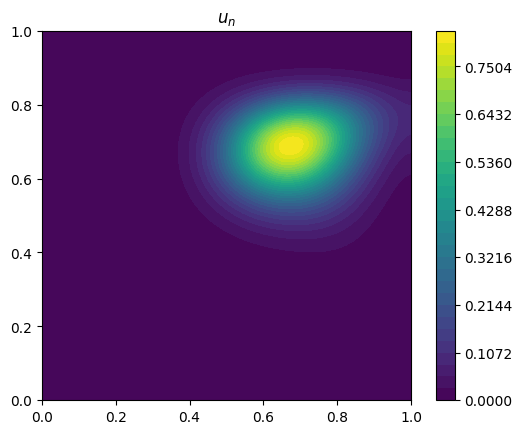

In [1]:
%matplotlib inline

from firedrake import *
from firedrake.pyplot import tricontourf

import matplotlib.pyplot as plt
import numpy as np

T = 0.1
N = 100
dt = Constant(T / N)

mesh = UnitSquareMesh(128, 128)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test = TestFunction(space)
trial = TrialFunction(space)

psi = Function(space, name="psi")
psi.interpolate(-sin(pi * X[0]) * sin(pi * X[1]))

kappa = Constant(0.01)

u_0 = Function(space, name="u_0")
u_0.interpolate(exp(-50.0 * ((X[0] - 0.75) ** 2 + (X[1] - 0.5) ** 2)))

u_n = Function(space, name="u_n")
u_np1 = Function(space, name="u_np1")

u_h = 0.5 * (u_n + trial)
F = (inner(trial - u_n, test) * dx
     + dt * inner(psi.dx(0) * u_h.dx(1) - psi.dx(1) * u_h.dx(0), test) * dx
     + dt * inner(kappa * grad(u_h), grad(test)) * dx)
lhs, rhs = system(F)

problem = LinearVariationalProblem(
    lhs, rhs, u_np1,
    constant_jacobian=True)
solver = LinearVariationalSolver(
    problem, solver_parameters={"ksp_type": "preonly",
                                "pc_type": "lu"})

u_n.assign(u_0)
for n in range(N):
    solver.solve()
    u_n.assign(u_np1)

J = assemble(inner(u_n, u_n) * dx)


def plot_output(u, title):
    r = (u.dat.data_ro.min(), u.dat.data_ro.max())
    eps = (r[1] - r[0]) * 1.0e-12
    p = tricontourf(u, np.linspace(r[0] - eps, r[1] + eps, 32))
    plt.gca().set_title(title)
    plt.colorbar(p)
    plt.gca().set_aspect(1.0)


plot_output(u_0, title="$u_0$")
plot_output(u_n, title="$u_n$")

## Adding tlm_adjoint

We first modify the code so that tlm_adjoint processes the calculations:

In [2]:
from firedrake import *
from tlm_adjoint.firedrake import *

reset_manager("memory", {})

T = 0.1
N = 100
dt = Constant(T / N)

mesh = UnitSquareMesh(128, 128)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test = TestFunction(space)
trial = TrialFunction(space)

psi = Function(space, name="psi")
psi.interpolate(-sin(pi * X[0]) * sin(pi * X[1]))

kappa = Constant(0.01)

u_0 = Function(space, name="u_0")
u_0.interpolate(exp(-50.0 * ((X[0] - 0.75) ** 2 + (X[1] - 0.5) ** 2)))


def forward(u_0, psi):
    u_n = Function(space, name="u_n")
    u_np1 = Function(space, name="u_np1")

    u_h = 0.5 * (u_n + trial)
    F = (inner(trial - u_n, test) * dx
         + dt * inner(psi.dx(0) * u_h.dx(1) - psi.dx(1) * u_h.dx(0), test) * dx
         + dt * inner(kappa * grad(u_h), grad(test)) * dx)
    lhs, rhs = system(F)

    problem = LinearVariationalProblem(
        lhs, rhs, u_np1,
        constant_jacobian=True)
    solver = LinearVariationalSolver(
        problem, solver_parameters={"ksp_type": "preonly",
                                    "pc_type": "lu"})

    u_n.assign(u_0)
    for n in range(N):
        solver.solve()
        u_n.assign(u_np1)

    J = Functional(name="J")
    J.assign(inner(u_n, u_n) * dx)
    return J


start_manager()
J = forward(u_0, psi)
stop_manager()

(True, True)

Later we will configure a checkpointing schedule. Resetting the manager resets the record of forward equations but does not reset the checkpointing configuration, and so in this example whenever we reset the manager we also return it to the default checkpointing configuration with `reset_manager("memory", {})`.

## Computing derivatives using an adjoint

The `compute_gradient` function can be used to compute derivatives using the adjoint method. Here we compute the derivative of the square of the $L^2$-norm of the final timestep solution, considered a function of the control defined by the initial condition `u_0` and stream function `psi`, with respect to this control:

In [3]:
dJ_du_0, dJ_dpsi = compute_gradient(J, (u_0, psi))

As a simple check of the result, note that the solution to the (discretized) partial differential equation is unchanged by the addition of a constant to the stream function. Hence we expect the directional derivative with respect to the stream function, with direction equal to the unity valued function, to be zero. This is indeed found to be the case (except for roundoff errors):

In [4]:
one = Function(space, name="one")
one.interpolate(Constant(1.0))

dJ_dpsi_one = assemble(action(dJ_dpsi, one))

print(f"{dJ_dpsi_one=}")

assert abs(dJ_dpsi_one) < 1.0e-17

dJ_dpsi_one=3.50741757937361e-18


## Computing Hessian information using an adjoint of a tangent-linear

We next compute a Hessian action. Although the following calculation does work, it is inefficient &ndash; you may wish to skip forward to the optimized calculations.

Here we compute a 'mixed' Hessian action, by defining a directional derivative with respect to the stream function, and then differentiating this with respect to the initial condition:

In [5]:
from firedrake import *
from tlm_adjoint.firedrake import *

reset_manager("memory", {})

T = 0.1
N = 100
dt = Constant(T / N)

mesh = UnitSquareMesh(128, 128)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test = TestFunction(space)
trial = TrialFunction(space)

psi = Function(space, name="psi")
psi.interpolate(-sin(pi * X[0]) * sin(pi * X[1]))

kappa = Constant(0.01)

u_0 = Function(space, name="u_0")
u_0.interpolate(exp(-50.0 * ((X[0] - 0.75) ** 2 + (X[1] - 0.5) ** 2)))


def forward(u_0, psi):
    u_n = Function(space, name="u_n")
    u_np1 = Function(space, name="u_np1")

    u_h = 0.5 * (u_n + trial)
    F = (inner(trial - u_n, test) * dx
         + dt * inner(psi.dx(0) * u_h.dx(1) - psi.dx(1) * u_h.dx(0), test) * dx
         + dt * inner(kappa * grad(u_h), grad(test)) * dx)
    lhs, rhs = system(F)

    problem = LinearVariationalProblem(
        lhs, rhs, u_np1,
        constant_jacobian=True)
    solver = LinearVariationalSolver(
        problem, solver_parameters={"ksp_type": "preonly",
                                    "pc_type": "lu"})

    u_n.assign(u_0)
    for n in range(N):
        solver.solve()
        u_n.assign(u_np1)

    J = Functional(name="J")
    J.assign(inner(u_n, u_n) * dx)
    return J


zeta = Function(space, name="zeta")
zeta.assign(psi)
configure_tlm((psi, zeta))

start_manager()
J = forward(u_0, psi)
stop_manager()

dJ_dpsi_zeta = var_tlm(J, (psi, zeta))

d2J_dpsi_zeta_du_0 = compute_gradient(dJ_dpsi_zeta, u_0)

## Optimization

In the above we have successfully built a record of calculations, and used this to compute derivative information. However there are two issues:

1. Building the record has a noticable cost &ndash; the forward calculation has slowed down. In the second order calculation overheads associated with the tangent-linear lead to substantial additional costs.
2. tlm_adjoint records the solution of the partial differential equation on all time levels. The memory usage here is manageable. However memory limits will be exceeded for larger problems with more fields, spatial degrees of freedom, or timesteps.

Let's fix these issues in order.

### Optimizing the annotation

In the above code tlm_adjoint builds a new record for each finite element variational problem it encounters. Even though only one `LinearVariationalSolver` is instantiated, an `EquationSolver` record is instantiated on each call to the `solve` method. Building the record is sufficiently expensive that the forward calculation noticeably slows down, and this also leads to significant extra processing in the derivative calculations.

Instead we can instantiate an `EquationSolver` directly, and reuse it. However if we do only that then the code will still be inefficient. A single `EquationSolver` will be used, but new linear solver data will be constructed each time its `solve` method is called. We need to also apply an optimization analogous to the `constant_jacobian=True` argument supplied to `LinearVariationalProblem`.

A simple fix is to add `cache_jacobian=True` when instantiating the `EquationSolver`:

```
eq = EquationSolver(
    lhs == rhs, u_np1,
    solver_parameters={"ksp_type": "preonly",
                       "pc_type": "lu"},
    cache_jacobian=True)
```

This works, but we can instead let tlm_adjoint detect that linear solver data can be cached. We can do that by adding `static=True` when instantiating variables whose value is unchanged throughout the forward calculation:

In [6]:
from firedrake import *
from tlm_adjoint.firedrake import *

reset_manager("memory", {})
clear_caches()

T = 0.1
N = 100
dt = Constant(T / N, static=True)

mesh = UnitSquareMesh(128, 128)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test = TestFunction(space)
trial = TrialFunction(space)

psi = Function(space, name="psi", static=True)
psi.interpolate(-sin(pi * X[0]) * sin(pi * X[1]))

kappa = Constant(0.01, static=True)

u_0 = Function(space, name="u_0", static=True)
u_0.interpolate(exp(-50.0 * ((X[0] - 0.75) ** 2 + (X[1] - 0.5) ** 2)))


def forward(u_0, psi):
    u_n = Function(space, name="u_n")
    u_np1 = Function(space, name="u_np1")

    u_h = 0.5 * (u_n + trial)
    F = (inner(trial - u_n, test) * dx
         + dt * inner(psi.dx(0) * u_h.dx(1) - psi.dx(1) * u_h.dx(0), test) * dx
         + dt * inner(kappa * grad(u_h), grad(test)) * dx)
    lhs, rhs = system(F)

    eq = EquationSolver(
        lhs == rhs, u_np1,
        solver_parameters={"ksp_type": "preonly",
                           "pc_type": "lu"})

    u_n.assign(u_0)
    for n in range(N):
        eq.solve()
        u_n.assign(u_np1)

    J = Functional(name="J")
    J.assign(inner(u_n, u_n) * dx)
    return J


start_manager()
J = forward(u_0, psi)
stop_manager()

(True, True)

If we now query the relevant tlm_adjoint caches:

In [7]:
print(f"{len(assembly_cache())=}")
print(f"{len(linear_solver_cache())=}")

assert len(assembly_cache()) == 2
assert len(linear_solver_cache()) == 1

len(assembly_cache())=2
len(linear_solver_cache())=1


we find that linear solver data associated with a single matrix has been cached. We also find that two assembled objects have been cached &ndash; it turns out that there are two cached matrices. As well as caching the matrix associated with the left-hand-side of the discrete problem, a matrix associated with the *right-hand-side* has been assembled and cached. Assembly of the right-hand-side has been converted into a matrix multiply. If we wished we could disable right-hand-side optimizations by adding `cache_rhs_assembly=False`:

```
eq = EquationSolver(
    lhs == rhs, u_np1,
    solver_parameters={"ksp_type": "preonly",
                       "pc_type": "lu"},
    cache_rhs_assembly=False)
```

### Using a checkpointing schedule

To address the storage issue we enable checkpointing. Here we enable binomial checkpointing with storage of a maximum of $10$ forward restart checkpoints in memory:

In [8]:
from firedrake import *
from tlm_adjoint.firedrake import *

import logging

logger = logging.getLogger("tlm_adjoint")
logger.setLevel(logging.DEBUG)
root_logger = logging.getLogger()
if len(logger.handlers) == 1:
    if len(root_logger.handlers) == 1:
        root_logger.handlers.pop()
    root_logger.addHandler(logger.handlers.pop())

reset_manager("memory", {})
clear_caches()

T = 0.1
N = 100
dt = Constant(T / N, static=True)

mesh = UnitSquareMesh(128, 128)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test = TestFunction(space)
trial = TrialFunction(space)

psi = Function(space, name="psi", static=True)
psi.interpolate(-sin(pi * X[0]) * sin(pi * X[1]))

kappa = Constant(0.01, static=True)

u_0 = Function(space, name="u_0", static=True)
u_0.interpolate(exp(-50.0 * ((X[0] - 0.75) ** 2 + (X[1] - 0.5) ** 2)))


def forward(u_0, psi):
    u_n = Function(space, name="u_n")
    u_np1 = Function(space, name="u_np1")

    u_h = 0.5 * (u_n + trial)
    F = (inner(trial - u_n, test) * dx
         + dt * inner(psi.dx(0) * u_h.dx(1) - psi.dx(1) * u_h.dx(0), test) * dx
         + dt * inner(kappa * grad(u_h), grad(test)) * dx)
    lhs, rhs = system(F)

    eq = EquationSolver(
        lhs == rhs, u_np1,
        solver_parameters={"ksp_type": "preonly",
                           "pc_type": "lu"})

    u_n.assign(u_0)
    for n in range(N):
        eq.solve()
        u_n.assign(u_np1)
        if n < N - 1:
            new_block()

    J = Functional(name="J")
    J.assign(inner(u_n, u_n) * dx)
    return J


configure_checkpointing("multistage", {"snaps_in_ram": 10, "blocks": N})
start_manager()
J = forward(u_0, psi)
stop_manager()

forward: forward advance to 9223372036854775807


forward: forward advance to 21


forward: save checkpoint data at 0 in RAM


forward: forward advance to 40


forward: save checkpoint data at 21 in RAM


forward: forward advance to 57


forward: save checkpoint data at 40 in RAM


forward: forward advance to 72


forward: save checkpoint data at 57 in RAM


forward: forward advance to 79


forward: save checkpoint data at 72 in RAM


forward: forward advance to 85


forward: save checkpoint data at 79 in RAM


forward: forward advance to 90


forward: save checkpoint data at 85 in RAM


forward: forward advance to 94


forward: save checkpoint data at 90 in RAM


forward: forward advance to 97


forward: save checkpoint data at 94 in RAM


forward: forward advance to 99


forward: save checkpoint data at 97 in RAM


forward: forward advance to 100


(True, True)

The key changes here are:

- Configuration of a checkpointing schedule using `configure_checkpointing`. Here binomial checkpointing is applied, with a maximum of $10$ forward restart checkpoints stored in memory, indicated using the `"snaps_in_ram"` parameter. The total number of steps is indicated using the `"blocks"` parameter.
- The indication of the steps using `new_block()`.

Extra logging output is also enabled so that we can see the details of the checkpointing schedule.

### Computing derivatives

We are now ready to compute derivatives. However a key restriction is that we can, with this checkpointing schedule, only perform the adjoint calculation *once* per forward calculation. We cannot call `compute_gradient` a second time, without first rerunning the entire forward calculation.

In the following we compute both first and second derivative information using a single adjoint calculation:

In [9]:
from firedrake import *
from tlm_adjoint.firedrake import *

import logging

logger = logging.getLogger("tlm_adjoint")
logger.setLevel(logging.DEBUG)
root_logger = logging.getLogger()
if len(logger.handlers) == 1:
    if len(root_logger.handlers) == 1:
        root_logger.handlers.pop()
    root_logger.addHandler(logger.handlers.pop())

reset_manager("memory", {})
clear_caches()

T = 0.1
N = 100
dt = Constant(T / N, static=True)

mesh = UnitSquareMesh(128, 128)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test = TestFunction(space)
trial = TrialFunction(space)

psi = Function(space, name="psi", static=True)
psi.interpolate(-sin(pi * X[0]) * sin(pi * X[1]))

kappa = Constant(0.01, static=True)

u_0 = Function(space, name="u_0", static=True)
u_0.interpolate(exp(-50.0 * ((X[0] - 0.75) ** 2 + (X[1] - 0.5) ** 2)))


def forward(u_0, psi):
    u_n = Function(space, name="u_n")
    u_np1 = Function(space, name="u_np1")

    u_h = 0.5 * (u_n + trial)
    F = (inner(trial - u_n, test) * dx
         + dt * inner(psi.dx(0) * u_h.dx(1) - psi.dx(1) * u_h.dx(0), test) * dx
         + dt * inner(kappa * grad(u_h), grad(test)) * dx)
    lhs, rhs = system(F)

    eq = EquationSolver(
        lhs == rhs, u_np1,
        solver_parameters={"ksp_type": "preonly",
                           "pc_type": "lu"})

    u_n.assign(u_0)
    for n in range(N):
        eq.solve()
        u_n.assign(u_np1)
        if n < N - 1:
            new_block()

    J = Functional(name="J")
    J.assign(inner(u_n, u_n) * dx)
    return J


zeta_u_0 = ZeroFunction(space, name="zeta_u_0")
zeta_psi = Function(space, name="zeta_psi", static=True)
zeta_psi.assign(psi)
configure_tlm(((u_0, psi), (zeta_u_0, zeta_psi)))

configure_checkpointing("multistage", {"snaps_in_ram": 10, "blocks": N})
start_manager()
J = forward(u_0, psi)
stop_manager()

dJ_dpsi_zeta = var_tlm(J, ((u_0, psi), (zeta_u_0, zeta_psi)))

dJ_du_0, dJ_dpsi, d2J_dpsi_zeta_du_0 = compute_gradient(
    dJ_dpsi_zeta, (zeta_u_0, zeta_psi, u_0))

forward: forward advance to 9223372036854775807


forward: forward advance to 21


forward: save checkpoint data at 0 in RAM


forward: forward advance to 40


forward: save checkpoint data at 21 in RAM


forward: forward advance to 57


forward: save checkpoint data at 40 in RAM


forward: forward advance to 72


forward: save checkpoint data at 57 in RAM


forward: forward advance to 79


forward: save checkpoint data at 72 in RAM


forward: forward advance to 85


forward: save checkpoint data at 79 in RAM


forward: forward advance to 90


forward: save checkpoint data at 85 in RAM


forward: forward advance to 94


forward: save checkpoint data at 90 in RAM


forward: forward advance to 97


forward: save checkpoint data at 94 in RAM


forward: forward advance to 99


forward: save checkpoint data at 97 in RAM


forward: forward advance to 100


reverse: adjoint step back to 99


reverse: load checkpoint data at 97 from RAM and keep


reverse: forward advance to 98


reverse: forward advance to 99


reverse: adjoint step back to 98


reverse: load checkpoint data at 97 from RAM and delete


reverse: forward advance to 98


reverse: adjoint step back to 97


reverse: load checkpoint data at 94 from RAM and keep


reverse: forward advance to 95


reverse: forward advance to 96


reverse: save checkpoint data at 95 in RAM


reverse: forward advance to 97


reverse: adjoint step back to 96


reverse: load checkpoint data at 95 from RAM and delete


reverse: forward advance to 96


reverse: adjoint step back to 95


reverse: load checkpoint data at 94 from RAM and delete


reverse: forward advance to 95


reverse: adjoint step back to 94


reverse: load checkpoint data at 90 from RAM and keep


reverse: forward advance to 91


reverse: forward advance to 92


reverse: save checkpoint data at 91 in RAM


reverse: forward advance to 93


reverse: save checkpoint data at 92 in RAM


reverse: forward advance to 94


reverse: adjoint step back to 93


reverse: load checkpoint data at 92 from RAM and delete


reverse: forward advance to 93


reverse: adjoint step back to 92


reverse: load checkpoint data at 91 from RAM and delete


reverse: forward advance to 92


reverse: adjoint step back to 91


reverse: load checkpoint data at 90 from RAM and delete


reverse: forward advance to 91


reverse: adjoint step back to 90


reverse: load checkpoint data at 85 from RAM and keep


reverse: forward advance to 86


reverse: forward advance to 87


reverse: save checkpoint data at 86 in RAM


reverse: forward advance to 88


reverse: save checkpoint data at 87 in RAM


reverse: forward advance to 89


reverse: save checkpoint data at 88 in RAM


reverse: forward advance to 90


reverse: adjoint step back to 89


reverse: load checkpoint data at 88 from RAM and delete


reverse: forward advance to 89


reverse: adjoint step back to 88


reverse: load checkpoint data at 87 from RAM and delete


reverse: forward advance to 88


reverse: adjoint step back to 87


reverse: load checkpoint data at 86 from RAM and delete


reverse: forward advance to 87


reverse: adjoint step back to 86


reverse: load checkpoint data at 85 from RAM and delete


reverse: forward advance to 86


reverse: adjoint step back to 85


reverse: load checkpoint data at 79 from RAM and keep


reverse: forward advance to 80


reverse: forward advance to 81


reverse: save checkpoint data at 80 in RAM


reverse: forward advance to 82


reverse: save checkpoint data at 81 in RAM


reverse: forward advance to 83


reverse: save checkpoint data at 82 in RAM


reverse: forward advance to 84


reverse: save checkpoint data at 83 in RAM


reverse: forward advance to 85


reverse: adjoint step back to 84


reverse: load checkpoint data at 83 from RAM and delete


reverse: forward advance to 84


reverse: adjoint step back to 83


reverse: load checkpoint data at 82 from RAM and delete


reverse: forward advance to 83


reverse: adjoint step back to 82


reverse: load checkpoint data at 81 from RAM and delete


reverse: forward advance to 82


reverse: adjoint step back to 81


reverse: load checkpoint data at 80 from RAM and delete


reverse: forward advance to 81


reverse: adjoint step back to 80


reverse: load checkpoint data at 79 from RAM and delete


reverse: forward advance to 80


reverse: adjoint step back to 79


reverse: load checkpoint data at 72 from RAM and keep


reverse: forward advance to 73


reverse: forward advance to 74


reverse: save checkpoint data at 73 in RAM


reverse: forward advance to 75


reverse: save checkpoint data at 74 in RAM


reverse: forward advance to 76


reverse: save checkpoint data at 75 in RAM


reverse: forward advance to 77


reverse: save checkpoint data at 76 in RAM


reverse: forward advance to 78


reverse: save checkpoint data at 77 in RAM


reverse: forward advance to 79


reverse: adjoint step back to 78


reverse: load checkpoint data at 77 from RAM and delete


reverse: forward advance to 78


reverse: adjoint step back to 77


reverse: load checkpoint data at 76 from RAM and delete


reverse: forward advance to 77


reverse: adjoint step back to 76


reverse: load checkpoint data at 75 from RAM and delete


reverse: forward advance to 76


reverse: adjoint step back to 75


reverse: load checkpoint data at 74 from RAM and delete


reverse: forward advance to 75


reverse: adjoint step back to 74


reverse: load checkpoint data at 73 from RAM and delete


reverse: forward advance to 74


reverse: adjoint step back to 73


reverse: load checkpoint data at 72 from RAM and delete


reverse: forward advance to 73


reverse: adjoint step back to 72


reverse: load checkpoint data at 57 from RAM and keep


reverse: forward advance to 59


reverse: forward advance to 61


reverse: save checkpoint data at 59 in RAM


reverse: forward advance to 63


reverse: save checkpoint data at 61 in RAM


reverse: forward advance to 65


reverse: save checkpoint data at 63 in RAM


reverse: forward advance to 67


reverse: save checkpoint data at 65 in RAM


reverse: forward advance to 69


reverse: save checkpoint data at 67 in RAM


reverse: forward advance to 71


reverse: save checkpoint data at 69 in RAM


reverse: forward advance to 72


reverse: adjoint step back to 71


reverse: load checkpoint data at 69 from RAM and keep


reverse: forward advance to 70


reverse: forward advance to 71


reverse: adjoint step back to 70


reverse: load checkpoint data at 69 from RAM and delete


reverse: forward advance to 70


reverse: adjoint step back to 69


reverse: load checkpoint data at 67 from RAM and keep


reverse: forward advance to 68


reverse: forward advance to 69


reverse: adjoint step back to 68


reverse: load checkpoint data at 67 from RAM and delete


reverse: forward advance to 68


reverse: adjoint step back to 67


reverse: load checkpoint data at 65 from RAM and keep


reverse: forward advance to 66


reverse: forward advance to 67


reverse: adjoint step back to 66


reverse: load checkpoint data at 65 from RAM and delete


reverse: forward advance to 66


reverse: adjoint step back to 65


reverse: load checkpoint data at 63 from RAM and keep


reverse: forward advance to 64


reverse: forward advance to 65


reverse: adjoint step back to 64


reverse: load checkpoint data at 63 from RAM and delete


reverse: forward advance to 64


reverse: adjoint step back to 63


reverse: load checkpoint data at 61 from RAM and keep


reverse: forward advance to 62


reverse: forward advance to 63


reverse: adjoint step back to 62


reverse: load checkpoint data at 61 from RAM and delete


reverse: forward advance to 62


reverse: adjoint step back to 61


reverse: load checkpoint data at 59 from RAM and keep


reverse: forward advance to 60


reverse: forward advance to 61


reverse: adjoint step back to 60


reverse: load checkpoint data at 59 from RAM and delete


reverse: forward advance to 60


reverse: adjoint step back to 59


reverse: load checkpoint data at 57 from RAM and keep


reverse: forward advance to 58


reverse: forward advance to 59


reverse: adjoint step back to 58


reverse: load checkpoint data at 57 from RAM and delete


reverse: forward advance to 58


reverse: adjoint step back to 57


reverse: load checkpoint data at 40 from RAM and keep


reverse: forward advance to 42


reverse: forward advance to 44


reverse: save checkpoint data at 42 in RAM


reverse: forward advance to 46


reverse: save checkpoint data at 44 in RAM


reverse: forward advance to 48


reverse: save checkpoint data at 46 in RAM


reverse: forward advance to 50


reverse: save checkpoint data at 48 in RAM


reverse: forward advance to 52


reverse: save checkpoint data at 50 in RAM


reverse: forward advance to 54


reverse: save checkpoint data at 52 in RAM


reverse: forward advance to 56


reverse: save checkpoint data at 54 in RAM


reverse: forward advance to 57


reverse: adjoint step back to 56


reverse: load checkpoint data at 54 from RAM and keep


reverse: forward advance to 55


reverse: forward advance to 56


reverse: adjoint step back to 55


reverse: load checkpoint data at 54 from RAM and delete


reverse: forward advance to 55


reverse: adjoint step back to 54


reverse: load checkpoint data at 52 from RAM and keep


reverse: forward advance to 53


reverse: forward advance to 54


reverse: adjoint step back to 53


reverse: load checkpoint data at 52 from RAM and delete


reverse: forward advance to 53


reverse: adjoint step back to 52


reverse: load checkpoint data at 50 from RAM and keep


reverse: forward advance to 51


reverse: forward advance to 52


reverse: adjoint step back to 51


reverse: load checkpoint data at 50 from RAM and delete


reverse: forward advance to 51


reverse: adjoint step back to 50


reverse: load checkpoint data at 48 from RAM and keep


reverse: forward advance to 49


reverse: forward advance to 50


reverse: adjoint step back to 49


reverse: load checkpoint data at 48 from RAM and delete


reverse: forward advance to 49


reverse: adjoint step back to 48


reverse: load checkpoint data at 46 from RAM and keep


reverse: forward advance to 47


reverse: forward advance to 48


reverse: adjoint step back to 47


reverse: load checkpoint data at 46 from RAM and delete


reverse: forward advance to 47


reverse: adjoint step back to 46


reverse: load checkpoint data at 44 from RAM and keep


reverse: forward advance to 45


reverse: forward advance to 46


reverse: adjoint step back to 45


reverse: load checkpoint data at 44 from RAM and delete


reverse: forward advance to 45


reverse: adjoint step back to 44


reverse: load checkpoint data at 42 from RAM and keep


reverse: forward advance to 43


reverse: forward advance to 44


reverse: adjoint step back to 43


reverse: load checkpoint data at 42 from RAM and delete


reverse: forward advance to 43


reverse: adjoint step back to 42


reverse: load checkpoint data at 40 from RAM and keep


reverse: forward advance to 41


reverse: forward advance to 42


reverse: adjoint step back to 41


reverse: load checkpoint data at 40 from RAM and delete


reverse: forward advance to 41


reverse: adjoint step back to 40


reverse: load checkpoint data at 21 from RAM and keep


reverse: forward advance to 23


reverse: forward advance to 25


reverse: save checkpoint data at 23 in RAM


reverse: forward advance to 27


reverse: save checkpoint data at 25 in RAM


reverse: forward advance to 29


reverse: save checkpoint data at 27 in RAM


reverse: forward advance to 31


reverse: save checkpoint data at 29 in RAM


reverse: forward advance to 33


reverse: save checkpoint data at 31 in RAM


reverse: forward advance to 35


reverse: save checkpoint data at 33 in RAM


reverse: forward advance to 37


reverse: save checkpoint data at 35 in RAM


reverse: forward advance to 39


reverse: save checkpoint data at 37 in RAM


reverse: forward advance to 40


reverse: adjoint step back to 39


reverse: load checkpoint data at 37 from RAM and keep


reverse: forward advance to 38


reverse: forward advance to 39


reverse: adjoint step back to 38


reverse: load checkpoint data at 37 from RAM and delete


reverse: forward advance to 38


reverse: adjoint step back to 37


reverse: load checkpoint data at 35 from RAM and keep


reverse: forward advance to 36


reverse: forward advance to 37


reverse: adjoint step back to 36


reverse: load checkpoint data at 35 from RAM and delete


reverse: forward advance to 36


reverse: adjoint step back to 35


reverse: load checkpoint data at 33 from RAM and keep


reverse: forward advance to 34


reverse: forward advance to 35


reverse: adjoint step back to 34


reverse: load checkpoint data at 33 from RAM and delete


reverse: forward advance to 34


reverse: adjoint step back to 33


reverse: load checkpoint data at 31 from RAM and keep


reverse: forward advance to 32


reverse: forward advance to 33


reverse: adjoint step back to 32


reverse: load checkpoint data at 31 from RAM and delete


reverse: forward advance to 32


reverse: adjoint step back to 31


reverse: load checkpoint data at 29 from RAM and keep


reverse: forward advance to 30


reverse: forward advance to 31


reverse: adjoint step back to 30


reverse: load checkpoint data at 29 from RAM and delete


reverse: forward advance to 30


reverse: adjoint step back to 29


reverse: load checkpoint data at 27 from RAM and keep


reverse: forward advance to 28


reverse: forward advance to 29


reverse: adjoint step back to 28


reverse: load checkpoint data at 27 from RAM and delete


reverse: forward advance to 28


reverse: adjoint step back to 27


reverse: load checkpoint data at 25 from RAM and keep


reverse: forward advance to 26


reverse: forward advance to 27


reverse: adjoint step back to 26


reverse: load checkpoint data at 25 from RAM and delete


reverse: forward advance to 26


reverse: adjoint step back to 25


reverse: load checkpoint data at 23 from RAM and keep


reverse: forward advance to 24


reverse: forward advance to 25


reverse: adjoint step back to 24


reverse: load checkpoint data at 23 from RAM and delete


reverse: forward advance to 24


reverse: adjoint step back to 23


reverse: load checkpoint data at 21 from RAM and keep


reverse: forward advance to 22


reverse: forward advance to 23


reverse: adjoint step back to 22


reverse: load checkpoint data at 21 from RAM and delete


reverse: forward advance to 22


reverse: adjoint step back to 21


reverse: load checkpoint data at 0 from RAM and keep


reverse: forward advance to 2


reverse: forward advance to 4


reverse: save checkpoint data at 2 in RAM


reverse: forward advance to 6


reverse: save checkpoint data at 4 in RAM


reverse: forward advance to 8


reverse: save checkpoint data at 6 in RAM


reverse: forward advance to 10


reverse: save checkpoint data at 8 in RAM


reverse: forward advance to 12


reverse: save checkpoint data at 10 in RAM


reverse: forward advance to 14


reverse: save checkpoint data at 12 in RAM


reverse: forward advance to 16


reverse: save checkpoint data at 14 in RAM


reverse: forward advance to 18


reverse: save checkpoint data at 16 in RAM


reverse: forward advance to 20


reverse: save checkpoint data at 18 in RAM


reverse: forward advance to 21


reverse: adjoint step back to 20


reverse: load checkpoint data at 18 from RAM and keep


reverse: forward advance to 19


reverse: forward advance to 20


reverse: adjoint step back to 19


reverse: load checkpoint data at 18 from RAM and delete


reverse: forward advance to 19


reverse: adjoint step back to 18


reverse: load checkpoint data at 16 from RAM and keep


reverse: forward advance to 17


reverse: forward advance to 18


reverse: adjoint step back to 17


reverse: load checkpoint data at 16 from RAM and delete


reverse: forward advance to 17


reverse: adjoint step back to 16


reverse: load checkpoint data at 14 from RAM and keep


reverse: forward advance to 15


reverse: forward advance to 16


reverse: adjoint step back to 15


reverse: load checkpoint data at 14 from RAM and delete


reverse: forward advance to 15


reverse: adjoint step back to 14


reverse: load checkpoint data at 12 from RAM and keep


reverse: forward advance to 13


reverse: forward advance to 14


reverse: adjoint step back to 13


reverse: load checkpoint data at 12 from RAM and delete


reverse: forward advance to 13


reverse: adjoint step back to 12


reverse: load checkpoint data at 10 from RAM and keep


reverse: forward advance to 11


reverse: forward advance to 12


reverse: adjoint step back to 11


reverse: load checkpoint data at 10 from RAM and delete


reverse: forward advance to 11


reverse: adjoint step back to 10


reverse: load checkpoint data at 8 from RAM and keep


reverse: forward advance to 9


reverse: forward advance to 10


reverse: adjoint step back to 9


reverse: load checkpoint data at 8 from RAM and delete


reverse: forward advance to 9


reverse: adjoint step back to 8


reverse: load checkpoint data at 6 from RAM and keep


reverse: forward advance to 7


reverse: forward advance to 8


reverse: adjoint step back to 7


reverse: load checkpoint data at 6 from RAM and delete


reverse: forward advance to 7


reverse: adjoint step back to 6


reverse: load checkpoint data at 4 from RAM and keep


reverse: forward advance to 5


reverse: forward advance to 6


reverse: adjoint step back to 5


reverse: load checkpoint data at 4 from RAM and delete


reverse: forward advance to 5


reverse: adjoint step back to 4


reverse: load checkpoint data at 2 from RAM and keep


reverse: forward advance to 3


reverse: forward advance to 4


reverse: adjoint step back to 3


reverse: load checkpoint data at 2 from RAM and delete


reverse: forward advance to 3


reverse: adjoint step back to 2


reverse: load checkpoint data at 0 from RAM and keep


reverse: forward advance to 1


reverse: forward advance to 2


reverse: adjoint step back to 1


reverse: load checkpoint data at 0 from RAM and delete


reverse: forward advance to 1


reverse: adjoint step back to 0


The derivative calculation now alternates between forward + tangent-linear calculations, and adjoint calculations.

If we wished we could perform higher order adjoint calculations, using a binomial checkpointing schedule, by supplying a higher order tangent-linear configuration and differentiating the result.